In [20]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

# Demand function

In [21]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

# Profit function

In [22]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [23]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Probability array

In [31]:
# Probability array for opponents choice
@jit(nopython=True)
def prob_array(Qtable, price_grid):
    prob_matrix = np.zeros((len(price_grid), len(price_grid)))

    for i in range(len(price_grid)): # loops over every row in Qtable
            prob_matrix[i] = Qtable[i, :] / np.sum(Qtable[i, :]) # for every column in row i we divide by the total number of the opponents actions

    return prob_matrix

# Expected profit

In [32]:
# Expected profit for each possible action
@jit(nopython=True)
def expected_profit(price_grid, prob_opponent):
    # Initialize profit_table and expected_profit_array
    profit_table = np.zeros((len(price_grid), len(price_grid)))
    expected_profit_array = np.zeros(len(price_grid))

    for i in range(len(price_grid)): # loops over every row in profit_table
        for j in range(len(price_grid)): # loops over every column in profit_table
            # Calculate every possible profit 
            profit_table[i, j] = profit(price_grid[i], price_grid[j]) * prob_opponent[i, j] # adding weight to each possible profit
        expected_profit_array[i] = np.sum(profit_table[i, :]) # calculating expected profit for each action
    
    return expected_profit_array

# Fictitious Play

In [33]:
@jit(nopython=True)
def FictitiousPlay(price_grid, period):
    # Initialize Q-tables and arrays
    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))
    Qtable_temp = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    # Period 0
    price_index_j = np.random.choice(len(price_grid)) 
    price_index_i = np.random.choice(len(price_grid)) 

    for t in range(1, period + 1):
        # Update Q-table based on the recent action of the opponent
        Qtable_i[:, price_index_j] += 1

        # Calculate the probability vector for the opponents actions
        prob_opponent = prob_array(Qtable_i, price_grid)

        # Calculate the expected profit for each action
        expected_profit_array = expected_profit(price_grid, prob_opponent)

        # Choosing the action with the largest expected profit
        price_index_i = np.argmax(expected_profit_array)

        # Calculate the profit for player i and j
        profit_opponent = profit(price_grid[price_index_j], price_grid[price_index_i])
        profit_i_current_period = profit(price_grid[price_index_i], price_grid[price_index_j])

        # Average profit in each period
        total_profit[t-1] = (profit_i_current_period + profit_opponent) / 2

        # Update the individual profit arrays
        if t % 2 == 0:
            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        else:
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent

        # Switch player for next period
        Qtable_temp = Qtable_j
        Qtable_j = Qtable_i
        Qtable_i = Qtable_temp
        price_index_j = price_index_i
    
    return total_profit, profit_1, profit_2

In [34]:
@jit(nopython=True)
def Simulations(sim, price_grid, period):
    # Initialize profit and average profit arrays
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array = FictitiousPlay(price_grid, period)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:]) # mean of the last 1000 periods
        avg_profit_2[i] = np.mean(profit_2_array[-1000:]) # mean of the last 1000 periods

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

# Time calculation for 1000 simulations

In [35]:
start_time  = time.time()

total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations(1000, P, 500000)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 261.3773958683014 seconds


# Profitability

In [36]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

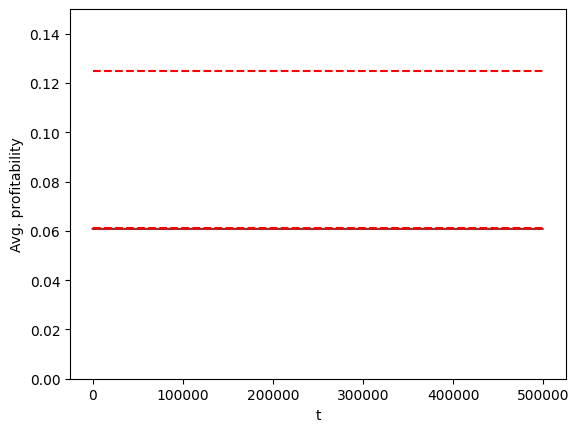

In [37]:
plt.plot(moving_averages, color='#a62626', label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.hlines(y=0.0611, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.hlines(y=0.125, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.show()

# Optimality

In [38]:
def delta_prof(avg_array_1, avg_array_2, sim):
    together_array = np.vstack((avg_array_1, avg_array_2))
    together_array_mean = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array_mean))
    for i in range(sim):
        delta_1[i] = ((together_array_mean[i]) / (0.125))
    return delta_1

In [39]:
#dividing delta into intervals
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
        #if delta_arr[i] == 1 :
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [40]:
delta_1 = delta_prof(avg_profit_1_plot, avg_profit_2_plot, 1000)

delta_2 = delta_div(delta_1)

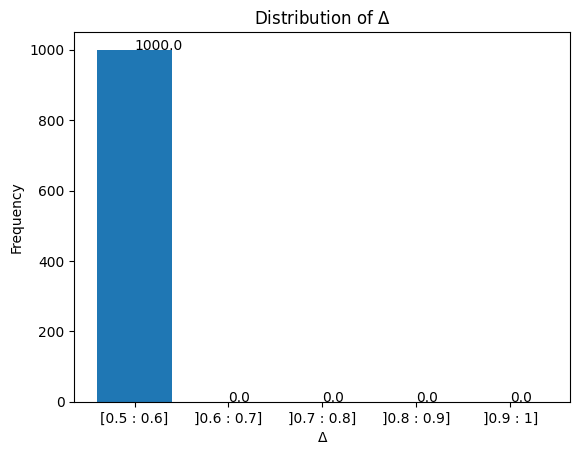

In [41]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

# Heatmap

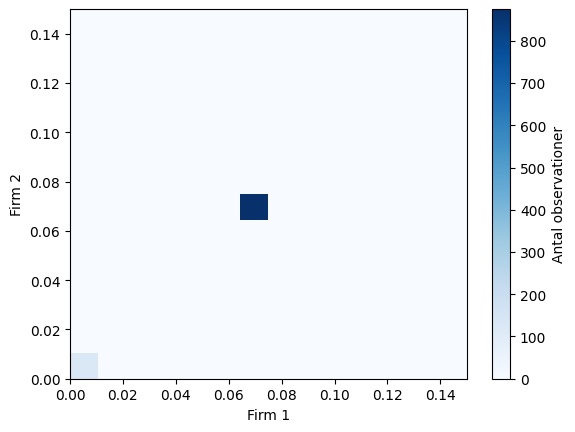

In [42]:
x_bins = np.linspace(0, 0.15, 15)
y_bins = np.linspace(0, 0.15, 15)

heatmap, xedges, yedges = np.histogram2d(avg_profit_1_plot, avg_profit_2_plot, bins=[x_bins, y_bins])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Blues', aspect='auto')
cb = plt.colorbar()
cb.set_label('Antal observationer')
plt.xlabel("Firm 1")
plt.ylabel("Firm 2")

plt.show()